In [1]:
!pip install mtcnn
!pip install lz4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.1 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import numpy as np
import cv2
from mtcnn import MTCNN
import os

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# --- Téléchargement et décompression du dataset ---
#!rm -rf /content/FER2013
#!kaggle datasets download msambare/fer2013 -p /content/FER2013
#!unzip -q /content/FER2013/fer2013.zip -d /content/FER2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 88% 53.0M/60.3M [00:00<00:00, 72.5MB/s]
100% 60.3M/60.3M [00:00<00:00, 82.2MB/s]


In [5]:

# --- Définir les chemins vers les données ---
data_dir_train = '/content/FER2013/train'
data_dir_test = '/content/FER2013/test'

In [6]:

# --- Création des datasets avec tf.data ---
batch_size = 64
img_size = (48, 48)

<ipython-input-7-e4d7f4a5c934>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")


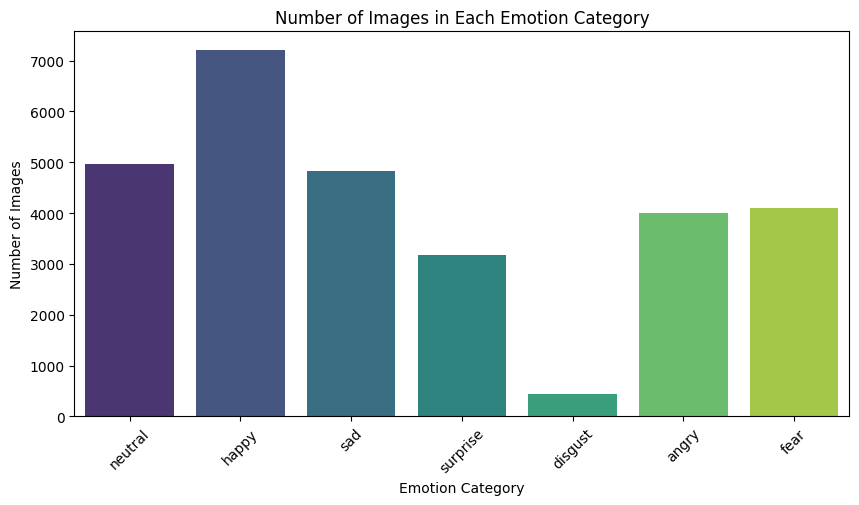

In [7]:


categories = os.listdir(data_dir_train)

image_counts = {category: len(os.listdir(os.path.join(data_dir_train, category))) for category in categories}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="viridis")
plt.xlabel("Emotion Category")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Emotion Category")
plt.xticks(rotation=45)
plt.show()



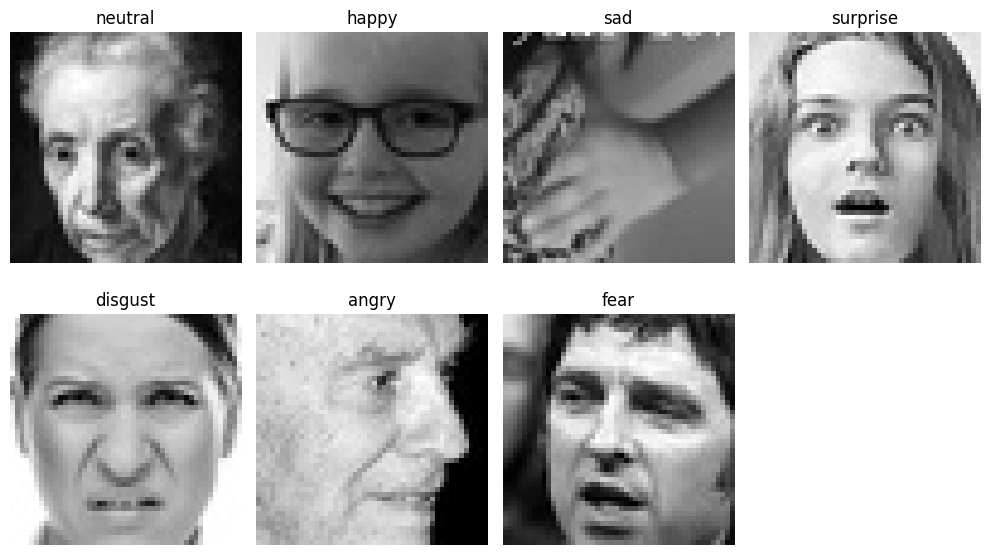

In [8]:
categories = os.listdir(data_dir_train)

plt.figure(figsize=(10, 6))

for i, category in enumerate(categories):
    category_path = os.path.join(data_dir_train, category)
    image_path = os.path.join(category_path, os.listdir(category_path)[0])  # Get first image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(category)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,           #  shifts the image horizontally by 10% of the total width
    height_shift_range=0.1,          # shifts the image vertically by 10% of the total height
    horizontal_flip=True,            # A left-facing car image might be flipped to a right-facing one
    rescale=1./255,                  #  improving training stability , Faster Convergence
    validation_split=0.2
)


test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    directory=data_dir_train,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    directory=data_dir_train,  # Use train_dir for validation
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    directory=data_dir_test,
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode="categorical"
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
model = tf.keras.Sequential([
        # input layer
        tf.keras.layers.Input(shape=(48,48,1)),  # Input() instead of input_shape in Conv2D
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # Flatten layer
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        # output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [15]:
# Définition des callbacks
callbacks = [
    # Sauvegarder le meilleur modèle
    ModelCheckpoint(filepath='best_model.h5',
                    monitor='val_accuracy',
                    save_best_only=True,
                    mode='max',
                    verbose=1),

    # Arrêter l'entraînement si la performance ne s'améliore plus
    EarlyStopping(monitor='val_loss',
                  patience=10,
                  restore_best_weights=True,
                  verbose=1),

    # Réduction du learning rate si la validation n'améliore pas
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.5,
                      patience=5,
                      verbose=1),
]

In [17]:
strategy = tf.distribute.MirroredStrategy()  # si vous avez plusieurs GPU


In [18]:
history = model.fit(x = train_generator,epochs = 70 ,
                    validation_data = validation_generator,
                    callbacks=callbacks)
# You can go for 100 epochs

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1820 - loss: 9.5724
Epoch 1: val_accuracy improved from -inf to 0.17331, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 96ms/step - accuracy: 0.1821 - loss: 9.5707 - val_accuracy: 0.1733 - val_loss: 9.2865 - learning_rate: 1.0000e-04
Epoch 2/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2218 - loss: 8.4917
Epoch 2: val_accuracy improved from 0.17331 to 0.26076, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.2219 - loss: 8.4903 - val_accuracy: 0.2608 - val_loss: 7.5890 - learning_rate: 1.0000e-04
Epoch 3/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2581 - loss: 7.5082
Epoch 3: val_accuracy improved from 0.26076 to 0.30099, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.2581 - loss: 7.5069 - val_accuracy: 0.3010 - val_loss: 6.6696 - learning_rate: 1.0000e-04
Epoch 4/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2757 - loss: 6.5560
Epoch 4: val_accuracy improved from 0.30099 to 0.33304, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2757 - loss: 6.5554 - val_accuracy: 0.3330 - val_loss: 5.7856 - learning_rate: 1.0000e-04
Epoch 5/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3053 - loss: 5.6789
Epoch 5: val_accuracy improved from 0.33304 to 0.36579, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.3053 - loss: 5.6778 - val_accuracy: 0.3658 - val_loss: 4.9522 - learning_rate: 1.0000e-04
Epoch 6/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3280 - loss: 4.9068
Epoch 6: val_accuracy improved from 0.36579 to 0.37433, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.3280 - loss: 4.9063 - val_accuracy: 0.3743 - val_loss: 4.3442 - learning_rate: 1.0000e-04
Epoch 7/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3581 - loss: 4.2462
Epoch 7: val_accuracy improved from 0.37433 to 0.40725, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.3581 - loss: 4.2458 - val_accuracy: 0.4072 - val_loss: 3.7484 - learning_rate: 1.0000e-04
Epoch 8/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3786 - loss: 3.6992
Epoch 8: val_accuracy improved from 0.40725 to 0.40951, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.3786 - loss: 3.6986 - val_accuracy: 0.4095 - val_loss: 3.3186 - learning_rate: 1.0000e-04
Epoch 9/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4133 - loss: 3.2410
Epoch 9: val_accuracy improved from 0.40951 to 0.46333, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.4134 - loss: 3.2406 - val_accuracy: 0.4633 - val_loss: 2.8652 - learning_rate: 1.0000e-04
Epoch 10/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4329 - loss: 2.8893
Epoch 10: val_accuracy did not improve from 0.46333
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.4329 - loss: 2.8890 - val_accuracy: 0.4461 - val_loss: 2.7690 - learning_rate: 1.0000e-04
Epoch 11/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4429 - loss: 2.6113
Epoch 11: val_accuracy improved from 0.46333 to 0.48180, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.4430 - loss: 2.6111 - val_accuracy: 0.4818 - val_loss: 2.3887 - learning_rate: 1.0000e-04
Epoch 12/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4707 - loss: 2.3634
Epoch 12: val_accuracy improved from 0.48180 to 0.49120, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.4707 - loss: 2.3633 - val_accuracy: 0.4912 - val_loss: 2.1831 - learning_rate: 1.0000e-04
Epoch 13/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4789 - loss: 2.1885
Epoch 13: val_accuracy improved from 0.49120 to 0.49591, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.4789 - loss: 2.1883 - val_accuracy: 0.4959 - val_loss: 2.0846 - learning_rate: 1.0000e-04
Epoch 14/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5003 - loss: 2.0332
Epoch 14: val_accuracy improved from 0.49591 to 0.52778, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.5003 - loss: 2.0330 - val_accuracy: 0.5278 - val_loss: 1.9039 - learning_rate: 1.0000e-04
Epoch 15/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5088 - loss: 1.9183
Epoch 15: val_accuracy improved from 0.52778 to 0.53614, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.5088 - loss: 1.9182 - val_accuracy: 0.5361 - val_loss: 1.7937 - learning_rate: 1.0000e-04
Epoch 16/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5161 - loss: 1.8297
Epoch 16: val_accuracy improved from 0.53614 to 0.54363, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.5161 - loss: 1.8297 - val_accuracy: 0.5436 - val_loss: 1.7249 - learning_rate: 1.0000e-04
Epoch 17/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5364 - loss: 1.7420
Epoch 17: val_accuracy improved from 0.54363 to 0.54520, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.5364 - loss: 1.7420 - val_accuracy: 0.5452 - val_loss: 1.7009 - learning_rate: 1.0000e-04
Epoch 18/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5386 - loss: 1.6904
Epoch 18: val_accuracy did not improve from 0.54520
359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.5386 - loss: 1.6903 - val_accuracy: 0.5367 - val_loss: 1.6665 - learning_rate: 1.0000e-04
Epoch 19/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5478 - loss: 1.6328
Epoch 19: val_accuracy improved from 0.54520 to 0.55600, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.5478 - loss: 1.6328 - val_accuracy: 0.5560 - val_loss: 1.6069 - learning_rate: 1.0000e-04
Epoch 20/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5555 - loss: 1.6085
Epoch 20: val_accuracy did not improve from 0.55600
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.5555 - loss: 1.6085 - val_accuracy: 0.5391 - val_loss: 1.6201 - learning_rate: 1.0000e-04
Epoch 21/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5638 - loss: 1.5764
Epoch 21: val_accuracy improved from 0.55600 to 0.56245, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.5638 - loss: 1.5764 - val_accuracy: 0.5624 - val_loss: 1.5590 - learning_rate: 1.0000e-04
Epoch 22/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5731 - loss: 1.5517
Epoch 22: val_accuracy improved from 0.56245 to 0.57255, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.5731 - loss: 1.5517 - val_accuracy: 0.5725 - val_loss: 1.5334 - learning_rate: 1.0000e-04
Epoch 23/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5797 - loss: 1.5179
Epoch 23: val_accuracy improved from 0.57255 to 0.58195, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.5797 - loss: 1.5181 - val_accuracy: 0.5820 - val_loss: 1.5014 - learning_rate: 1.0000e-04
Epoch 24/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5863 - loss: 1.5032
Epoch 24: val_accuracy did not improve from 0.58195
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5863 - loss: 1.5032 - val_accuracy: 0.5760 - val_loss: 1.5020 - learning_rate: 1.0000e-04
Epoch 25/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5885 - loss: 1.4920
Epoch 25: val_accuracy improved from 0.58195 to 0.58544, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.5884 - loss: 1.4920 - val_accuracy: 0.5854 - val_loss: 1.4920 - learning_rate: 1.0000e-04
Epoch 26/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5859 - loss: 1.4773
Epoch 26: val_accuracy improved from 0.58544 to 0.58770, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.5859 - loss: 1.4773 - val_accuracy: 0.5877 - val_loss: 1.4763 - learning_rate: 1.0000e-04
Epoch 27/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5958 - loss: 1.4621
Epoch 27: val_accuracy did not improve from 0.58770
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.5957 - loss: 1.4621 - val_accuracy: 0.5847 - val_loss: 1.4719 - learning_rate: 1.0000e-04
Epoch 28/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5993 - loss: 1.4575
Epoch 28: val_accuracy did not improve from 0.58770
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5993 - loss: 1.4575 - val_accuracy: 0.5630 - val_loss: 1.5418 - learning_rate: 1.0000e-04
Epoch 29/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5936 - loss: 1.4460
Epoch 29: val_accuracy did not improve from 0.58770
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.5936 - loss: 1.4460 - val_accuracy: 0.5839 - val_loss: 1.5228 - learning_rate: 1.0

359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.6010 - loss: 1.4289 - val_accuracy: 0.6025 - val_loss: 1.4336 - learning_rate: 1.0000e-04
Epoch 31/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6018 - loss: 1.4318
Epoch 31: val_accuracy improved from 0.60251 to 0.60373, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6018 - loss: 1.4318 - val_accuracy: 0.6037 - val_loss: 1.4465 - learning_rate: 1.0000e-04
Epoch 32/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6068 - loss: 1.4228
Epoch 32: val_accuracy did not improve from 0.60373
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.6068 - loss: 1.4229 - val_accuracy: 0.5900 - val_loss: 1.4573 - learning_rate: 1.0000e-04
Epoch 33/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6116 - loss: 1.4255
Epoch 33: val_accuracy did not improve from 0.60373
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6116 - loss: 1.4255 - val_accuracy: 0.5898 - val_loss: 1.4647 - learning_rate: 1.0000e-04
Epoch 34/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6211 - loss: 1.4058
Epoch 34: val_accuracy improved from 0.60373 to 0.61209, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.6211 - loss: 1.4059 - val_accuracy: 0.6121 - val_loss: 1.4260 - learning_rate: 1.0000e-04
Epoch 35/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6127 - loss: 1.4038
Epoch 35: val_accuracy did not improve from 0.61209
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.6127 - loss: 1.4038 - val_accuracy: 0.5867 - val_loss: 1.5163 - learning_rate: 1.0000e-04
Epoch 36/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6229 - loss: 1.3902
Epoch 36: val_accuracy did not improve from 0.61209
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.6228 - loss: 1.3903 - val_accuracy: 0.5518 - val_loss: 1.5543 - learning_rate: 1.0000e-04
Epoch 37/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6319 - loss: 1.3711
Epoch 37: val_accuracy did not improve from 0.61209
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6319 - loss: 1.3712 - val_accuracy: 0.6006 - val_loss: 1.4549 - learning_rate: 1.0

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6363 - loss: 1.3541 - val_accuracy: 0.6250 - val_loss: 1.3584 - learning_rate: 5.0000e-05
Epoch 41/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6445 - loss: 1.3084
Epoch 41: val_accuracy did not improve from 0.62498
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.6445 - loss: 1.3084 - val_accuracy: 0.6166 - val_loss: 1.3643 - learning_rate: 5.0000e-05
Epoch 42/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6475 - loss: 1.2816
Epoch 42: val_accuracy improved from 0.62498 to 0.63107, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.6475 - loss: 1.2816 - val_accuracy: 0.6311 - val_loss: 1.3335 - learning_rate: 5.0000e-05
Epoch 43/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6623 - loss: 1.2520
Epoch 43: val_accuracy improved from 0.63107 to 0.63526, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6623 - loss: 1.2520 - val_accuracy: 0.6353 - val_loss: 1.3129 - learning_rate: 5.0000e-05
Epoch 44/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6539 - loss: 1.2558
Epoch 44: val_accuracy did not improve from 0.63526
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6538 - loss: 1.2558 - val_accuracy: 0.6204 - val_loss: 1.3417 - learning_rate: 5.0000e-05
Epoch 45/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6669 - loss: 1.2235
Epoch 45: val_accuracy did not improve from 0.63526
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.6669 - loss: 1.2235 - val_accuracy: 0.6283 - val_loss: 1.3160 - learning_rate: 5.0000e-05
Epoch 46/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6682 - loss: 1.2125
Epoch 46: val_accuracy did not improve from 0.63526
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6681 - loss: 1.2126 - val_accuracy: 0.6246 - val_loss: 1.3537 - learning_rate: 5.0

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6752 - loss: 1.1855 - val_accuracy: 0.6373 - val_loss: 1.3097 - learning_rate: 5.0000e-05
Epoch 53/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6807 - loss: 1.1717
Epoch 53: val_accuracy did not improve from 0.63735
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.6807 - loss: 1.1718 - val_accuracy: 0.6346 - val_loss: 1.3127 - learning_rate: 5.0000e-05
Epoch 54/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6761 - loss: 1.1870
Epoch 54: val_accuracy did not improve from 0.63735

Epoch 54: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.6761 - loss: 1.1870 - val_accuracy: 0.6304 - val_loss: 1.3184 - learning_rate: 5.0000e-05
Epoch 55/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6836 - loss: 1.1629
Epoch 55: val_accuracy improved from 0.63735 to 0.64275, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.6837 - loss: 1.1629 - val_accuracy: 0.6427 - val_loss: 1.2951 - learning_rate: 2.5000e-05
Epoch 56/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6904 - loss: 1.1439
Epoch 56: val_accuracy improved from 0.64275 to 0.64466, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.6904 - loss: 1.1438 - val_accuracy: 0.6447 - val_loss: 1.2861 - learning_rate: 2.5000e-05
Epoch 57/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6950 - loss: 1.1254
Epoch 57: val_accuracy improved from 0.64466 to 0.64658, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6950 - loss: 1.1253 - val_accuracy: 0.6466 - val_loss: 1.2812 - learning_rate: 2.5000e-05
Epoch 58/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6960 - loss: 1.1072
Epoch 58: val_accuracy did not improve from 0.64658
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6960 - loss: 1.1072 - val_accuracy: 0.6420 - val_loss: 1.2833 - learning_rate: 2.5000e-05
Epoch 59/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7015 - loss: 1.0975
Epoch 59: val_accuracy did not improve from 0.64658
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.7015 - loss: 1.0975 - val_accuracy: 0.6426 - val_loss: 1.2733 - learning_rate: 2.5000e-05
Epoch 60/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7079 - loss: 1.0797
Epoch 60: val_accuracy did not improve from 0.64658
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.7079 - loss: 1.0797 - val_accuracy: 0.6448 - val_loss: 1.2698 - learning_rate: 2.5

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.7174 - loss: 1.0381 - val_accuracy: 0.6562 - val_loss: 1.2638 - learning_rate: 1.2500e-05
Epoch 67/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7256 - loss: 1.0113
Epoch 67: val_accuracy did not improve from 0.65616
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7256 - loss: 1.0113 - val_accuracy: 0.6485 - val_loss: 1.2568 - learning_rate: 1.2500e-05
Epoch 68/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7275 - loss: 1.0023
Epoch 68: val_accuracy did not improve from 0.65616
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.7275 - loss: 1.0023 - val_accuracy: 0.6516 - val_loss: 1.2493 - learning_rate: 1.2500e-05
Epoch 69/70
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7302 - loss: 1.0054
Epoch 69: val_accuracy improved from 0.65616 to 0.65685, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7302 - loss: 1.0054 - val_accuracy: 0.6569 - val_loss: 1.2542 - learning_rate: 1.2500e-05
Epoch 70/70
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7318 - loss: 0.9880
Epoch 70: val_accuracy improved from 0.65685 to 0.65825, saving model to best_model.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7318 - loss: 0.9881 - val_accuracy: 0.6582 - val_loss: 1.2510 - learning_rate: 1.2500e-05
Restoring model weights from the end of the best epoch: 68.


In [19]:
loss, acc = model.evaluate(test_generator)
print(f"Final Test Accuracy: {acc * 100:.2f}%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6658 - loss: 1.2389
Final Test Accuracy: 66.55%


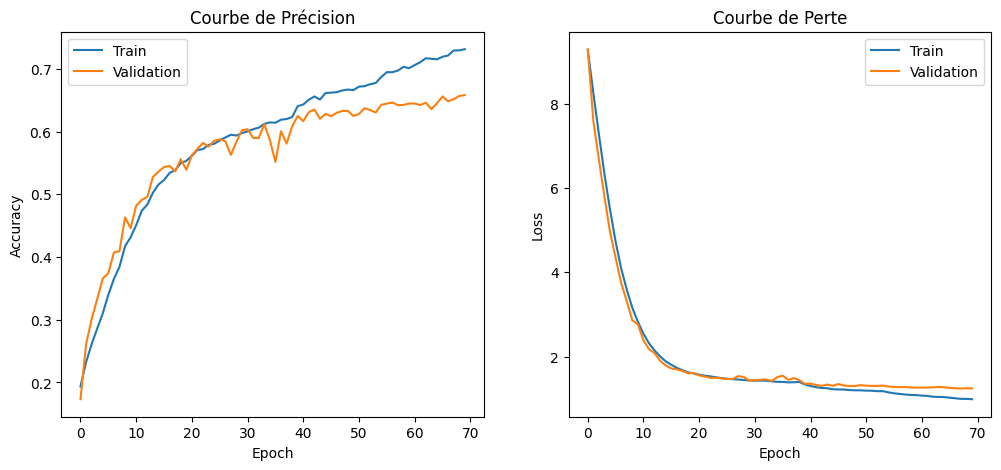

In [20]:
plt.figure(figsize=(12, 5))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Courbe de Précision')

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Courbe de Perte')

plt.show()
